
### 1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>. You have to use data.csv file for this assignment
### 2. Code the model to classify data like below image. You can use any number of units in your Dense layers.

<img src='https://i.imgur.com/33ptOFy.png'>



# <font color='red'> <b>3. Writing Callbacks </b> </font>
## You have to implement the following callbacks
-  Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.Do not use tf.keras.metrics for calculating AUC and F1 score.

- Save your model at every epoch if your validation accuracy is improved from previous epoch. 

- You have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.
        
- If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 

- You have to stop the training if your validation accuracy is not increased in last 2 epochs.

- Use tensorboard for every model and analyse your scalar plots and histograms. (you need to upload the screenshots and write the observations for each model for evaluation)



In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import datetime

In [2]:
df = pd.read_csv("data.csv")
df.columns

Index(['f1', 'f2', 'label'], dtype='object')

In [3]:
X = np.array(df[['f1','f2']])
y = np.array(df['label'])

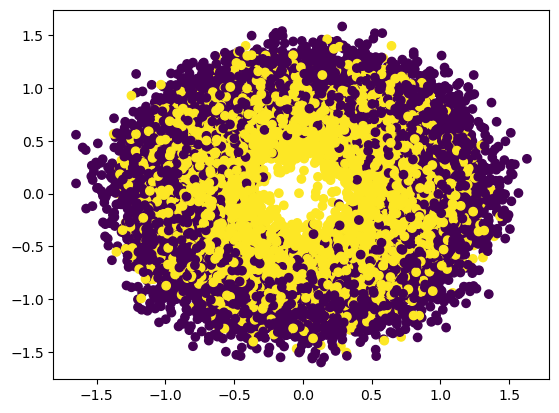

In [4]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42,stratify=y)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size=0.12,stratify=y_train)

<pre>
<b>Model-1</b>
<pre>
1. Use columnsh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [6]:
from sklearn.metrics import f1_score,roc_auc_score
def mosel_hp(layers,act,intializer):
    
    input_layer =  tf.keras.layers.Input(shape=(X_train.shape[1],))
    layer_1 = tf.keras.layers.Dense(layers[0],activation=act, kernel_initializer=intializer)(input_layer)
    layer_2 = tf.keras.layers.Dense(layers[1],activation=act, kernel_initializer=intializer)(layer_1)
    layer_3 = tf.keras.layers.Dense(layers[2],activation=act, kernel_initializer=intializer)(layer_2)
    layer_4 = tf.keras.layers.Dense(layers[3],activation=act, kernel_initializer=intializer)(layer_3)
    layer_5 = tf.keras.layers.Dense(layers[4],activation=act, kernel_initializer=intializer)(layer_4)
    output_layer = tf.keras.layers.Dense(1,activation='sigmoid', kernel_initializer = intializer)(layer_5)

    model = tf.keras.Model(input_layer,output_layer)

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.3)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

class ModelMetric(tf.keras.callbacks.Callback):
    
    def __init__(self,validation_data):
        self.x_cv = validation_data[0]
        self.y_cv = validation_data[1]
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [],'f1_score': [],'auc': []}

    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
        
        model_weights = self.model.get_weights()
        if model_weights is not None:
            if np.any([np.any(np.isnan(x)) for x in model_weights]):
                print("Invalid weight and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
            
        if self.model.stop_training == False:
            print("Model Metric")
            true_positives=0
            ## on end of each epoch, we will get logs and update the self.history dict
            self.history['loss'].append(logs.get('loss'))
            self.history['accuracy'].append(logs.get('accuracy'))

            if logs.get('val_loss', -1) != -1:
                self.history['val_loss'].append(logs.get('val_loss'))
            if logs.get('val_accuracy', -1) != -1:
                self.history['val_accuracy'].append(logs.get('val_accuracy'))
            # we can get a list of all predicted values at the end of the epoch
            # we can use these predicted value and the true values to calculate any custom evaluation score if it is needed for our model
            # Here we are taking log of all true positives and then taking average of it
            y_prob_pred= self.model.predict(self.x_cv)
            y_pred = np.zeros(shape=y_prob_pred.shape)
            y_pred[ y_prob_pred > 0 ] = 1
            print(y_prob_pred.shape,y_pred.shape)
            f1_s = f1_score(self.y_cv,y_pred,average='micro')
            roc_auc = roc_auc_score(self.y_cv,y_prob_pred,average='micro')
            #we can also calcualte predefined metrics such as precison, recall, etc. using callbacks 
            self.history['f1_score'].append(f1_s)
            self.history['auc'].append(roc_auc)
            print(' f1_score: ',f1_s,' Roc Area: ',roc_auc)

In [7]:
def lr_setter(epoch,lr):
    if epoch%3 == 0:
        return lr*(0.95)
    return lr

logs = ModelMetric((X_cv,y_cv))
filepath   = "model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
lrschedule = tf.keras.callbacks.LearningRateScheduler(lr_setter, verbose=1)
reduce     = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.9,patience=1,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.005, patience=1, verbose=1)
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
all_callbacks = [checkpoint,lrschedule,reduce,early_stop,logs,tensorboard_callback]

In [8]:
inti = tf.keras.initializers.RandomUniform(minval= 0,maxval=1)
layers = [8,16,8,4,2]

model_1 = mosel_hp(layers=layers,act='sigmoid',intializer=inti)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 1)                 3     

2022-10-03 12:22:44.556434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home2/sisodiya.bhoomendra/venvs/global/lib/
2022-10-03 12:22:44.556466: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-03 12:22:44.557349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [9]:
model_1.fit(X_train,y_train,epochs=10, validation_data=(X_cv,y_cv), batch_size=8,callbacks = all_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/10
1733/1760 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4991
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model_save/weights-01-0.5000.hdf5
Model Metric
60/60 [==============================] - 0s 1ms/step
(1920, 1) (1920, 1)
 f1_score:  0.5  Roc Area:  0.48557345920138884
1760/1760 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4990 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - lr: 0.0095

Epoch 2: LearningRateScheduler setting learning rate to 0.009499999694526196.
Epoch 2/10
1757/1760 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5003
Epoch 2: val_accuracy did not improve from 0.50000

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.008549999725073577.
1760/1760 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - 

In [10]:
!tensorboard dev upload --logdir logs --name Model_1 

2022-10-03 12:22:57.925977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home2/sisodiya.bhoomendra/venvs/global/lib/
2022-10-03 12:22:57.926022: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/50eKXRRtQ3WPJvBg14vkWQ/

[2022-10-03T12:22:59] Started scanning logdir.
[2022-10-03T12:23:01] Total uploaded: 14 scal

![Model 1 ](Model_1/Model_1.png)![Model 1 ](Model_1/Model_11.png)

Blue color is or validation and orange is for train and based on this it is clear that after 1 epoch their is no change in validation accuracy and because of that we had an early stop

<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [11]:
inti = tf.keras.initializers.RandomUniform(minval= 0,maxval=1)
layers = [8,16,8,8,2]

model_2 = mosel_hp(layers=layers,act='relu',intializer=inti)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 24        
                                                                 
 dense_7 (Dense)             (None, 16)                144       
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_9 (Dense)             (None, 8)                 72        
                                                                 
 dense_10 (Dense)            (None, 2)                 18        
                                                                 
 dense_11 (Dense)            (None, 1)                 3   

In [13]:
model_2.fit(X_train,y_train,epochs=10, validation_data=(X_cv,y_cv), batch_size=8,callbacks = all_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/10
1731/1760 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.5012
Epoch 1: val_accuracy did not improve from 0.50000
Invalid loss and terminated at epoch 0
1760/1760 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.5004 - val_loss: nan - val_accuracy: 0.5000 - lr: 0.0095


In [14]:
!tensorboard dev upload --logdir logs --name Model_2

2022-10-03 12:28:39.419748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home2/sisodiya.bhoomendra/venvs/global/lib/
2022-10-03 12:28:39.419790: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/hobo0SObQFKlhV4AZPEj8A/

[2022-10-03T12:28:40] Started scanning logdir.
[2022-10-03T12:28:42] Total uploaded: 7 scala

![](Model_1/Model_2.png)

This means that the traning stoped just after the first epoch and that happend because of NaN values in the loss after the end of first epoch

<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [15]:
inti = tf.keras.initializers.he_uniform()
layers = [8,2,1,1,1]

model_3 = mosel_hp(layers=layers,act='relu',intializer=inti)
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 8)                 24        
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
 dense_15 (Dense)            (None, 1)                 2         
                                                                 
 dense_16 (Dense)            (None, 1)                 2         
                                                                 
 dense_17 (Dense)            (None, 1)                 2   

In [16]:
model_3.fit(X_train,y_train,epochs=10, validation_data=(X_cv,y_cv), batch_size=2,callbacks=all_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/10
7033/7040 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4991
Epoch 1: val_accuracy did not improve from 0.50000
Model Metric
60/60 [==============================] - 0s 1ms/step
(1920, 1) (1920, 1)
 f1_score:  0.5  Roc Area:  0.5
7040/7040 [==============================] - 13s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4994 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - lr: 0.0095

Epoch 2: LearningRateScheduler setting learning rate to 0.009499999694526196.
Epoch 2/10
7029/7040 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5003
Epoch 2: val_accuracy did not improve from 0.50000

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.008549999725073577.
7040/7040 [==============================] - 12s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - lr: 0.0095
Epoch 2: early stopping


In [17]:
!tensorboard dev upload --logdir logs --name Model_3

2022-10-03 12:30:18.179391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home2/sisodiya.bhoomendra/venvs/global/lib/
2022-10-03 12:30:18.179427: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/qKUWZcY4RNaZ4Vryew28XQ/

[2022-10-03T12:30:19] Started scanning logdir.
[2022-10-03T12:30:21] Total uploaded: 14 scal

![Model 1 ](Model_1/Model_3.png)

As their is no change in accuracy earlystop callback is invoked 




<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [18]:
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],))
layer_1 = tf.keras.layers.Dense(20,activation='sigmoid', kernel_initializer=tf.keras.initializers.he_uniform())(input_layer)
output_layer = tf.keras.layers.Dense(1,activation='sigmoid', kernel_initializer = tf.keras.initializers.he_uniform())(layer_1)

model = tf.keras.Model(input_layer,output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
model.fit(X_train,y_train,epochs=30, validation_data=(X_cv,y_cv), batch_size=4,callbacks=all_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/30
3488/3520 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.5996
Epoch 1: val_accuracy improved from 0.50000 to 0.67396, saving model to model_save/weights-01-0.6740.hdf5
Model Metric
60/60 [==============================] - 0s 1ms/step
(1920, 1) (1920, 1)
 f1_score:  0.5  Roc Area:  0.7326888020833333
3520/3520 [==============================] - 6s 2ms/step - loss: 0.6617 - accuracy: 0.5999 - val_loss: 0.6153 - val_accuracy: 0.6740 - lr: 0.0095

Epoch 2: LearningRateScheduler setting learning rate to 0.009499999694526196.
Epoch 2/30
3500/3520 [============================>.] - ETA: 0s - loss: 0.6100 - accuracy: 0.6634
Epoch 2: val_accuracy did not improve from 0.67396

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.008549999725073577.
Model Metric
60/60 [==============================] - 0s 1ms/step
(1920, 1) (1920, 1)
 f1_score:  0.5  Roc Area:  0.7297005208333334
3

In [20]:
y_pred = model.predict(X_test)

125/125 [==============================] - 0s 1ms/step


In [21]:
from sklearn.metrics import log_loss
print("This is log loss :",log_loss(y_test,y_pred))

This is log loss : 0.6033783882688731


In [22]:
!tensorboard dev upload --logdir logs --name Model_4

2022-10-03 12:33:38.659389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home2/sisodiya.bhoomendra/venvs/global/lib/
2022-10-03 12:33:38.659428: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/pnc8zjtyTJ2pQrGN68AjZQ/

[2022-10-03T12:33:39] Started scanning logdir.
[2022-10-03T12:33:41] Total uploaded: 28 scal

![](Model_1/Model_4_1.png) ![](Model_1/Model_4_2.png)

In the First Epoch only we got the best validation accuracy and after two more epoch there is no not much change so earlystop call back was executed 

# Note 
Make sure that you are plotting tensorboard plots either in your notebook or you can try to create a pdf file with all the tensorboard screenshots.Please write your analysis of tensorboard results for each model.
